# Example of use of the mlexplorer() function

Author: Charles Le Losq

**The `rampy.mlexplorer` class is in development. It aims to allow exploring sets of spectroscopic data with using principal component analysis or non-negative matrix factorization for instance. For now the work-in-progress version of this function is made available in this notebook.**

It will perform automatic data scaling and provides access to popular data mining algorithms from scikit-learn.

Main goal is to provide easy access to PCA, NMF and so on. It is not intended to perform multivariate curve resolution analysis, which is the goal of the PyMCR library that integrates well with Rampy.

Any help/feedback is more than welcome!

In [1]:
%matplotlib inline
import numpy as np
np.random.seed(42) # fixing the seed
import matplotlib
import matplotlib.pyplot as plt
import rampy as rp
from scipy.stats import norm

from sklearn.decomposition import PCA, NMF
import sklearn

Number of samples:40
Shape of partial spectra matrix:(2, 60)
Shape of concentration matrix:(40, 2)


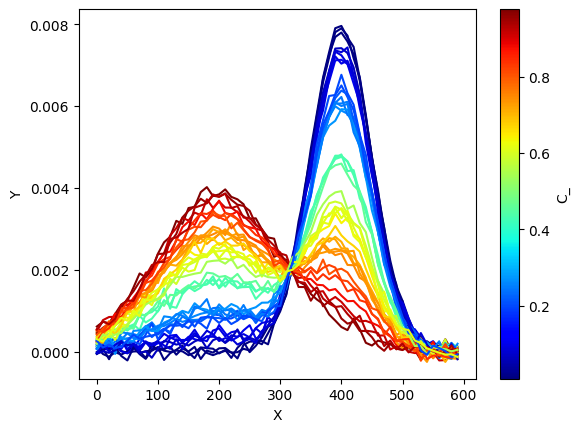

In [3]:
x = np.arange(0,600,10.0)
nb_samples = 40 # number of samples in our dataset

S_1 = norm.pdf(x,loc=200.,scale=100.)
S_2 = norm.pdf(x,loc=400,scale=50)
S_true = np.vstack((S_1,S_2))
print("Number of samples:"+str(nb_samples))
print("Shape of partial spectra matrix:"+str(S_true.shape))

C_ = np.random.rand(nb_samples) #60 samples with random concentrations between 0 and 1
C_true = np.vstack((C_,(1-C_))).T
print("Shape of concentration matrix:"+str(C_true.shape))

Obs = np.dot(C_true,S_true) + np.random.randn(nb_samples,len(x))*1e-4

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm_ = matplotlib.colors.Normalize(
    vmin=np.min(C_),
    vmax=np.max(C_))

# choose a colormap
c_m = matplotlib.cm.jet

# create a ScalarMappable and initialize a data structure
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm_)
s_m.set_array([])

ax = plt.subplot()

# plotting spectra
# calling the ScalarMappable that was initialised with c_m and norm
for i in range(C_.shape[0]):
    plt.plot(x,
             Obs[i,:].T,
             color=s_m.to_rgba(C_[i]))

# we plot the colorbar, using again our
# ScalarMappable
c_bar = plt.colorbar(s_m, ax=ax)
c_bar.set_label(r"C_")

plt.xlabel('X')
plt.ylabel('Y')
plt.show()

We create an mlexplorer object called 'explo'

In [4]:
explo = rp.mlexplorer(Obs)

We will explore the data with a Non-Negative Matrix factorisation algorithm, training it with 2 components on 70% of the data. MinMax scaling is performed before training.

In [5]:
explo.algorithm = 'NMF'
explo.nb_compo = 2
explo.test_size = 0.3
explo.scaler = "MinMax"
explo.fit()

The code uses the functions from scikit-learn, if you want a low-level control, you can define everything using the scikit-learn API and manipulating the model.

Training and testing data (original and scaled) are embedded into the object, as well as the scaler and model.

In [6]:
print("Example of X data (testing):")
print(explo.X_test[1,1:5])
print("\nScaler :")
print(explo.X_scaler)
print("\nModel :")
print(explo.model)

Example of X data (testing):
[0.00057493 0.000589   0.00081001 0.00083645]

Scaler :
MinMaxScaler()

Model :
NMF(init='nndsvd', n_components=2)


Please directly see the scikit-learn documentation for information about their PCA and NMF algorithms.

We can use directly the model to extract the W and H matrix and plot them, following the scikit-learn API:

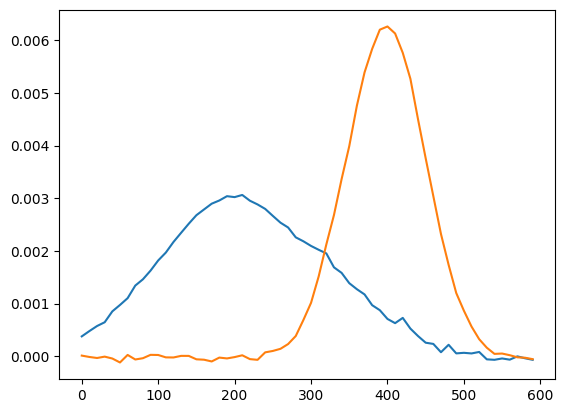

In [7]:
W = explo.model.transform(explo.X_train_sc) # mixture array
H = explo.X_scaler.inverse_transform(explo.model.components_) # components in the original space
plt.plot(x,H.T) # plot

We can modify hyperparameter and refit the data with the refit function.

NMF(init='nndsvd', max_iter=4000, n_components=2, tol=1e-12)


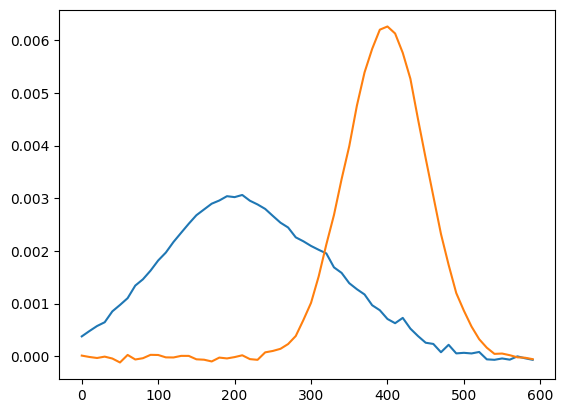

In [8]:
explo.model.tol=1e-12
explo.model.n_components=2
explo.model.max_iter = 4000
explo.model.solver="cd"
explo.model.alpha=0.1
print(explo.model)
explo.refit()
W = explo.model.transform(explo.X_train_sc) # mixture array
H = explo.X_scaler.inverse_transform(explo.model.components_) # components in the original space
plt.plot(x,H.T)

Now if we try a PCA...

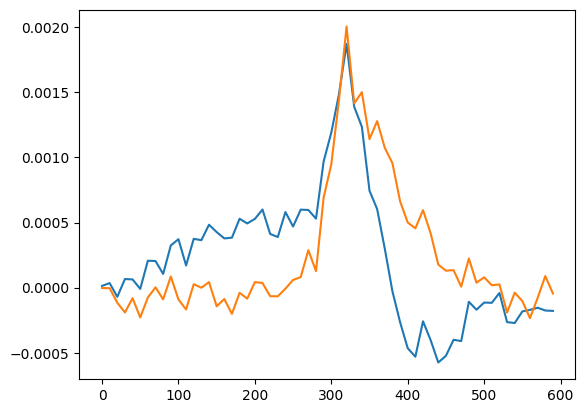

In [9]:
explo.algorithm = 'PCA'
explo.nb_compo = 2
explo.fit()

H_PCA = explo.X_scaler.inverse_transform(explo.model.components_)
plt.plot(x,H_PCA.T)